# Sketch out a Map for Timeseries and Find Good Places #

In [1]:
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np

from salishsea_tools import viz_tools, places, nc_tools, geo_tools

from importlib import reload

%matplotlib inline

/home/sallen/anaconda/envs/nowcast-fig-dev/lib/python3.6/site-packages/xarray/core/formatting.py:16: FutureWarning: The pandas.tslib module is deprecated and will be removed in a future version.
  from pandas.tslib import OutOfBoundsDatetime


## Get Grid Information from Bathymetry File ##

In [8]:
grid = nc.Dataset('/results/nowcast-sys/NEMO-forcing/grid/bathymetry_201702.nc')
bathy = grid.variables['Bathymetry'][:]
nav_lon = grid.variables['nav_lon'][:]
nav_lat = grid.variables['nav_lat'][:]

## Current Places + S3 ##

In [9]:
S3_lat = 49 + 7.5/60.
S3_lon = - (123 + 33.5/60.)

In [8]:
def nearest_search(nav_lon, nav_lat, stn_lon, stn_lat):
    '''
    ==========================================================
    Search the nearest grid point for a given station
        method: cKDTree (scipy.spatial.cKDTree)
        input: latitude and longitude as degrees
            ------- Yingkai Sha <yingkai@eos.ubc.ca>
    ----------------------------------------------------------
        stn_indx, stn_indy = nearest_search(nav_lon, nav_lat,
             stn_lon, stn_lat)
    ==========================================================
    '''
    from scipy.spatial import cKDTree # <-- The only function uses cKDTree
    # Create KDTree
    grids_list = list(zip(nav_lon.ravel(), nav_lat.ravel()))
    point_list = list(zip(stn_lon, stn_lat))
    domainTree = cKDTree(grids_list)
    # Nearest search
    _, index_flat = domainTree.query(point_list)
    stn_indx, stn_indy = np.unravel_index(index_flat, np.shape(nav_lon))
    return stn_indx, stn_indy

In [16]:
%%timeit
index_x, index_y = nearest_search(nav_lon, nav_lat, [S3_lon], [S3_lat])

682 ms ± 10.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [18]:
index_x, index_y = nearest_search(nav_lon, nav_lat, [S3_lon], [S3_lat])
print (index_x, index_y)

[450] [258]


In [6]:
%%timeit
index_geo_x, index_geo_y = geo_tools.find_closest_model_point(S3_lon, S3_lat, nav_lon, nav_lat)

2.35 ms ± 162 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [8]:
index_geo_x, index_geo_y = geo_tools.find_closest_model_point(S3_lon, S3_lat, nav_lon, nav_lat)
print(index_geo_x, index_geo_y)

450 258


For a single point, find_closest_model_point is 300x faster than nearest_search

S3 was added to places.py

In [23]:
def background_map():
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    viz_tools.set_aspect(ax)
    cmap = plt.get_cmap('Blues')
    cmap.set_bad('burlywood')
    mesh = ax.pcolormesh(bathy, cmap=cmap, vmax=1000.)
    return ax

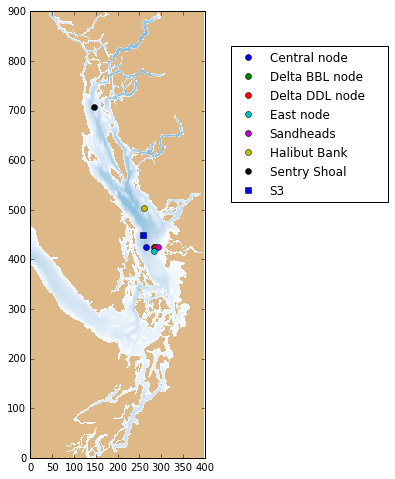

In [21]:
water_places = ['Central node', 'Delta BBL node', 'Delta DDL node', 'East node','Sandheads', \
               'Halibut Bank', 'Sentry Shoal', 'S3']

ax = background_map()

for countpoint, place in enumerate(water_places):
    point = places.PLACES[place]['NEMO grid ji']
    if countpoint < 7:
        ax.plot(point[1], point[0], 'o', label=place)
    else:
        ax.plot(point[1], point[0], 's', label=place)

ax.legend(
    loc='upper right',
    bbox_to_anchor=(1.15, 0.82, 0.9, .102),
    ncol=1,
    mode="expand",
    borderaxespad=0.,
    numpoints=1);

## Load Debby's Sampling Points

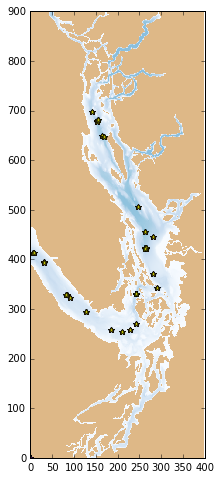

In [22]:
data = np.loadtxt('/ocean/ssahu/MEOPAR/salishseasprint/debby_stations.txt')
ax = background_map()
debby_x = np.empty(data.shape[0])
debby_y = np.empty_like(debby_x)
for i, datum in enumerate(data):
    debby_y[i], debby_x[i] = geo_tools.find_closest_model_point(datum[7], datum[6], nav_lon, nav_lat)
    ax.plot(debby_x, debby_y, '*')

## Now look for regularly sampled station inside Tereza's Clusters

In [26]:
biology = nc.Dataset('/ocean/ssahu/MEOPAR/salishseasprint/biology_clusters.nc')

d_stn_x = biology.variables['stn_x'][:]
d_stn_y = biology.variables['stn_y'][:]
bio_non_norm = biology.variables['bio_non_norm'][:]

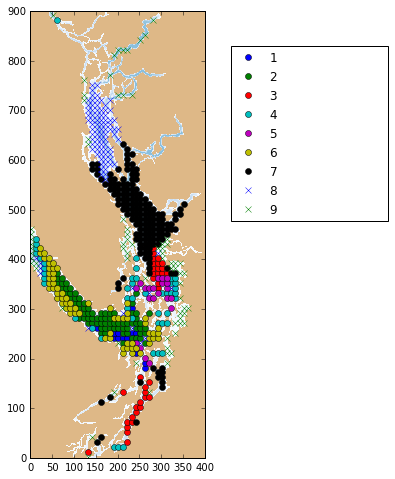

In [28]:
ax = background_map()

for cluster in range(1, 8):
    ax.plot(d_stn_x[bio_non_norm == cluster], d_stn_y[bio_non_norm == cluster], 'o', label=cluster)
for cluster in range(8, 10):    
    ax.plot(d_stn_x[bio_non_norm == cluster], d_stn_y[bio_non_norm == cluster], 'x', label=cluster)

ax.legend(
    loc='upper right',
    bbox_to_anchor=(1.15, 0.82, 0.9, .102),
    ncol=1,
    mode="expand",
    borderaxespad=0.,
    numpoints=1);

### Cluster 1

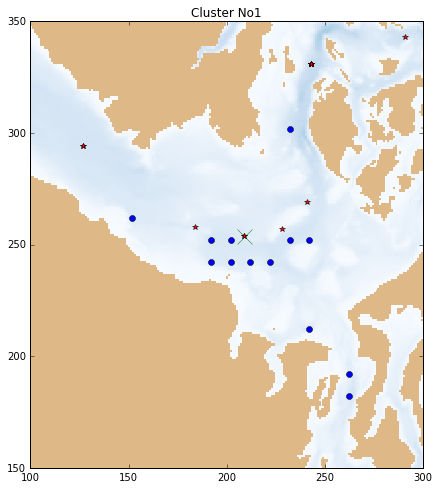

In [33]:
cluster = 1
imin = 150; imax=350; jmin=100; jmax=300
ax = background_map()
ax.plot(d_stn_x[bio_non_norm == cluster], d_stn_y[bio_non_norm == cluster], 'o')
ax.set_title('Cluster No' + str(cluster));
ax.plot(places.PLACES['Cluster_'+str(cluster)]['NEMO grid ji'][1], 
        places.PLACES['Cluster_'+str(cluster)]['NEMO grid ji'][0], 'x', markersize=15);
ax.plot(debby_x, debby_y, '*')
ax.set_xlim((jmin, jmax))
ax.set_ylim((imin, imax));

None of Debby's points correspond well to this cluster and its small: ignore

### Cluster 2

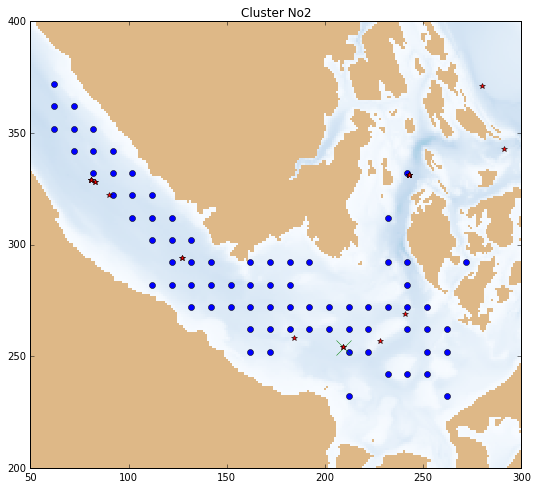

In [35]:
cluster = 2
imin = 200; imax=400; jmin=50; jmax=300
ax = background_map()
ax.plot(d_stn_x[bio_non_norm == cluster], d_stn_y[bio_non_norm == cluster], 'o')
ax.set_title('Cluster No' + str(cluster));
ax.plot(places.PLACES['Cluster_'+str(cluster)]['NEMO grid ji'][1], 
        places.PLACES['Cluster_'+str(cluster)]['NEMO grid ji'][0], 'x', markersize=15)
ax.plot(debby_x, debby_y, '*')
ax.set_xlim((jmin, jmax))
ax.set_ylim((imin, imax));

### Cluster 3

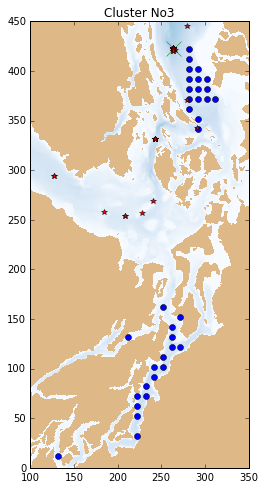

In [36]:
cluster = 3
imin = 0; imax=450; jmin=100; jmax=350
ax = background_map()
ax.plot(d_stn_x[bio_non_norm == cluster], d_stn_y[bio_non_norm == cluster], 'o')
ax.set_title('Cluster No' + str(cluster));
ax.plot(places.PLACES['Cluster_'+str(cluster)]['NEMO grid ji'][1], 
        places.PLACES['Cluster_'+str(cluster)]['NEMO grid ji'][0], 'x', markersize=15)
ax.plot(debby_x, debby_y, '*')
ax.set_xlim((jmin, jmax))
ax.set_ylim((imin, imax));

### Cluster 4

(0, 897)

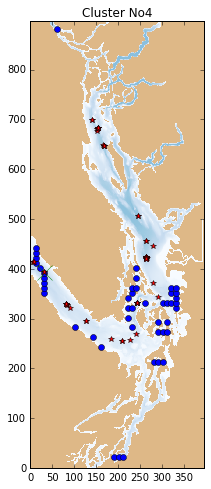

In [37]:
cluster = 4
imin = 0
imax = 897
jmin = 0
jmax = 397
ax = background_map()
ax.plot(d_stn_x[bio_non_norm == cluster] - jmin,
        d_stn_y[bio_non_norm == cluster] - imin, 'o')
ax.set_title('Cluster No' + str(cluster))
ax.plot(
    places.PLACES['Cluster_' + str(cluster)]['NEMO grid ji'][1],
    places.PLACES['Cluster_' + str(cluster)]['NEMO grid ji'][0],
    'x',
    markersize=15)
ax.plot(debby_x, debby_y, '*')
ax.set_xlim((jmin, jmax))
ax.set_ylim((imin, imax))

None of the Debby's points appropriate for this cluster.

### Cluster 5

(150, 400)

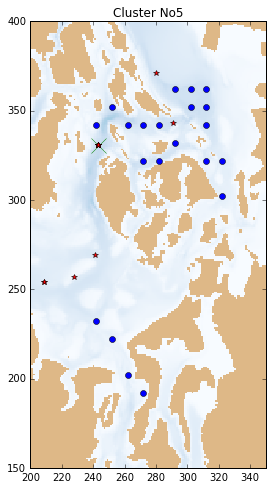

In [38]:
cluster = 5
imin = 150
imax = 400
jmin = 200
jmax = 350

ax = background_map()
ax.plot(d_stn_x[bio_non_norm == cluster], d_stn_y[bio_non_norm == cluster],
        'o')
ax.set_title('Cluster No' + str(cluster))
ax.plot(
    places.PLACES['Cluster_' + str(cluster)]['NEMO grid ji'][1],
    places.PLACES['Cluster_' + str(cluster)]['NEMO grid ji'][0],
    'x',
    markersize=15)
ax.plot(debby_x, debby_y, '*')
ax.set_xlim((jmin, jmax))
ax.set_ylim((imin, imax))

### Cluster 6

(175, 450)

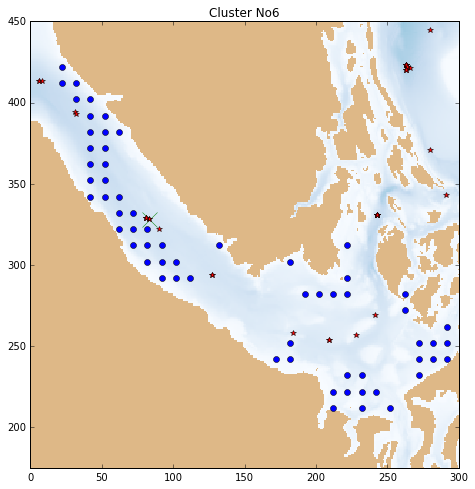

In [40]:
cluster = 6
imin = 175
imax = 450
jmin = 0
jmax = 300
ax = background_map()
ax.plot(d_stn_x[bio_non_norm == cluster],
        d_stn_y[bio_non_norm == cluster], 'o')
ax.set_title('Cluster No' + str(cluster))
ax.plot(places.PLACES['Cluster_' + str(cluster)]['NEMO grid ji'][1],
        places.PLACES['Cluster_' + str(cluster)]['NEMO grid ji'][0],
        'x',
    markersize=15)
ax.plot(debby_x, debby_y, '*')
ax.set_xlim((jmin, jmax))
ax.set_ylim((imin, imax));

Debby's points miss this one too

### Cluster 7

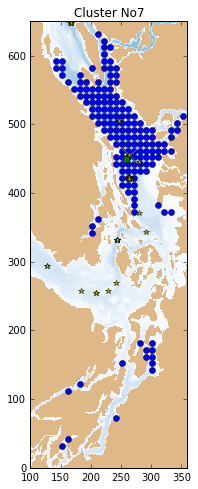

In [46]:
cluster = 7
imin = 0
imax = 650
jmin = 100
jmax = 360
ax = background_map()
ax.plot(d_stn_x[bio_non_norm == cluster], d_stn_y[bio_non_norm == cluster],
        'o')
ax.set_title('Cluster No' + str(cluster))
ax.plot(
    places.PLACES['Cluster_' + str(cluster)]['NEMO grid ji'][1],
    places.PLACES['Cluster_' + str(cluster)]['NEMO grid ji'][0],
    'xy',
    markersize=15)
ax.plot(places.PLACES['S3']['NEMO grid ji'][1],
        places.PLACES['S3']['NEMO grid ji'][0], 'gs')
ax.plot(debby_x, debby_y, 'y*')
ax.set_xlim((jmin, jmax))
ax.set_ylim((imin, imax));

### Cluster 8

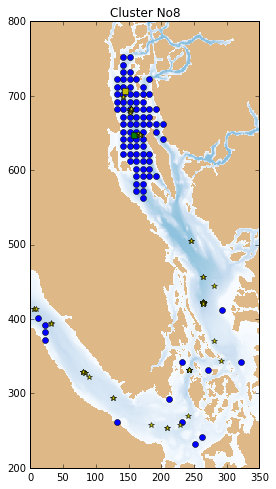

In [52]:
cluster = 8
imin = 200
imax = 800
jmin = 0
jmax = 350
ax = background_map()
ax.plot(d_stn_x[bio_non_norm == cluster], d_stn_y[bio_non_norm == cluster],
        'o')
ax.set_title('Cluster No' + str(cluster))
ax.plot(
    places.PLACES['Cluster_' + str(cluster)]['NEMO grid ji'][1],
    places.PLACES['Cluster_' + str(cluster)]['NEMO grid ji'][0],
    'gs')
ax.plot(debby_x, debby_y, 'y*')
ax.set_xlim((jmin, jmax))
ax.set_ylim((imin, imax))
ax.plot(places.PLACES['Sentry Shoal']['NEMO grid ji'][1],
        places.PLACES['Sentry Shoal']['NEMO grid ji'][0], 'ys');

Chosen point is not one of Debby's stations!

### Cluster 9

(0, 897)

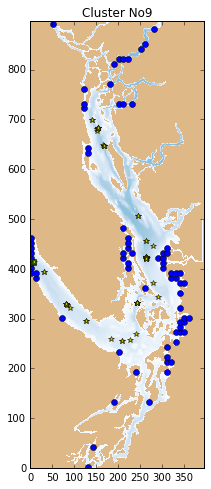

In [54]:
cluster = 9
imin = 0
imax = 897
jmin = 0
jmax = 397
ax = background_map()
ax.plot(d_stn_x[bio_non_norm == cluster],
        d_stn_y[bio_non_norm == cluster], 'o')
ax.set_title('Cluster No' + str(cluster))
ax.plot(places.PLACES['Cluster_' + str(cluster)]['NEMO grid ji'][1],
        places.PLACES['Cluster_' + str(cluster)]['NEMO grid ji'][0],
        'gs')
ax.plot(debby_x, debby_y, 'y*')
ax.set_xlim((jmin, jmax))
ax.set_ylim((imin, imax))

## Final Places Map

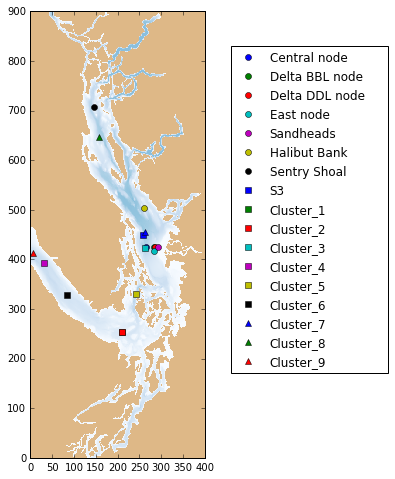

In [57]:
reload(places)
water_places = ['Central node', 'Delta BBL node', 'Delta DDL node', 'East node','Sandheads', \
               'Halibut Bank', 'Sentry Shoal', 'S3', 'Cluster_1', 'Cluster_2',\
          'Cluster_3', 'Cluster_4', 'Cluster_5', 'Cluster_6', 'Cluster_7', 'Cluster_8', 'Cluster_9']
ax = background_map()

for countpoint, place in enumerate(water_places):
    point = places.PLACES[place]['NEMO grid ji']
    if countpoint < 7:
        ax.plot(point[1], point[0], 'o', label=place)
    elif countpoint < 14:
        ax.plot(point[1], point[0], 's', label=place)
    else:
        ax.plot(point[1], point[0], '^', label=place)
    
ax.legend(loc='upper right', bbox_to_anchor=(1.15, 0.82, 0.9, .102), ncol=1, mode="expand", borderaxespad=0., numpoints=1);